In [1]:
from __future__ import division
import numpy as np

from astropy import table

import astropyp

% matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

def gaussian(amplitude, x, y, x0, y0, sigma_x, sigma_y):
    return amplitude*np.exp(-.5*( (x-x0)**2/sigma_x**2+ (y-y0)**2/sigma_y**2))

np.random.seed(1)

src_count = 50
objs = np.random.random((src_count,2))*260+20
#amplitudes = np.random.random((src_count,))*5000+100
amplitudes = np.random.exponential(500,(src_count,))+100

Y,X = np.indices((300,300))
noise = np.random.poisson(10000,X.size).reshape(X.shape)*1e-3
data = noise
for amp,obj_pos in zip(amplitudes, objs):
    #g = gaussian(amp,X,Y,obj_pos[1],obj_pos[0],5/2.355,5/2.355)
    g = gaussian(amp,X,Y,obj_pos[0],obj_pos[1],5/2.355,5/2.355)
    
    data += g

In [2]:
# Use psf instead
Y,X = np.indices((300,300))
noise = np.random.poisson(10000,X.size).reshape(X.shape)*1e-3
data = noise
radius = 10
X = np.linspace(-radius,radius,2*radius+1)
Y = np.linspace(-radius,radius,2*radius+1)
X,Y = np.meshgrid(X,Y)
g_psf = gaussian(1,X,Y,0,0,5/2.355,5/2.355)
for amp,obj_pos in zip(amplitudes, objs):
    idx1 = slice(obj_pos[1]-radius,obj_pos[1]+radius+1)
    idx2 = slice(obj_pos[0]-radius,obj_pos[0]+radius+1)
    data[idx1,idx2]=g_psf*amp

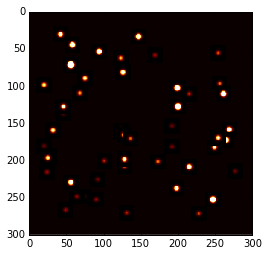

In [3]:
img = plt.imshow(data,cmap='afmhot',interpolation='none') 
norm = matplotlib.colors.Normalize(vmin=0, vmax=500) 
img.set_norm(norm)
plt.show()

INFO:astropyp.phot.psf:Total sources: 41
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 20
INFO:astropyp.phot.psf:Sources with bad pixels: 0
INFO:astropyp.phot.psf:Elliptical sources: 2
INFO:astropyp.phot.psf:Source with close neighbors: 20
INFO:astropyp.phot.psf:Sources near an edge: 0
INFO:astropyp.phot.psf:Sources after cuts: 9
/media/data-beta/users/fmooleka/anaconda/envs/pyp27/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


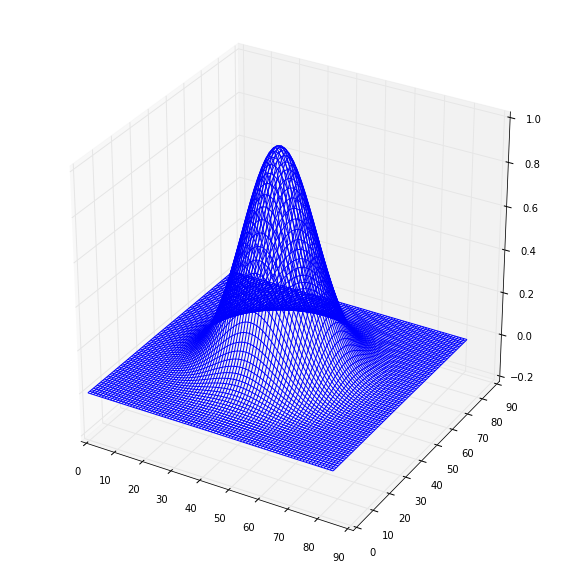

21720.6776087
31883.0165043
36959.9017882
7252.08540421
33768.4905117
5184.36921787
10768.1219016
95445.3961203
22575.0903251
15662.8055518
7516.75614427


In [13]:
import sep
conv_filter = np.array([
    [0.030531, 0.065238, 0.112208, 0.155356, 0.173152, 0.155356, 0.112208, 0.065238, 0.030531],
    [0.065238, 0.139399, 0.239763, 0.331961, 0.369987, 0.331961, 0.239763, 0.139399, 0.065238],
    [0.112208, 0.239763, 0.412386, 0.570963, 0.636368, 0.570963, 0.412386, 0.239763, 0.112208],
    [0.155356, 0.331961, 0.570963, 0.790520, 0.881075, 0.790520, 0.570963, 0.331961, 0.155356],
    [0.173152, 0.369987, 0.636368, 0.881075, 0.982004, 0.881075, 0.636368, 0.369987, 0.173152],
    [0.155356, 0.331961, 0.570963, 0.790520, 0.881075, 0.790520, 0.570963, 0.331961, 0.155356],
    [0.112208, 0.239763, 0.412386, 0.570963, 0.636368, 0.570963, 0.412386, 0.239763, 0.112208],
    [0.065238, 0.139399, 0.239763, 0.331961, 0.369987, 0.331961, 0.239763, 0.139399, 0.065238],
    [0.030531, 0.065238, 0.112208, 0.155356, 0.173152, 0.155356, 0.112208, 0.065238, 0.030531]
])

# SExtractor 'extract' detection parameters
sex_params = {
    'extract': {
        'thresh': 50,# *bkg.globalrms,
        #'err':,
        #'minarea': 5, # default
        'conv': conv_filter,
        #'deblend_nthresh': 32, #default
        'deblend_cont': 0.001,
        #'clean': True, #default
        #'clean_param': 1 #default
    },
    'kron_k': 2.5,
    'kron_min_radius': 3.5,
    'filter': conv_filter,
    'thresh': 1.5
}

ccd = astropyp.phot.phot.SingleImage(img=data, gain=4., exptime=30, aper_radius=8)
ccd.detect_sources(sex_params)
ccd.select_psf_sources(1000,500, badpix_flags=[])
psf_array = ccd.create_psf()
ccd.show_psf()
ccd.perform_psf_photometry()

rms 0.0274800324258
mean 0.00666537292275
median 1.87339656656e-06
stddev 0.0266594258363


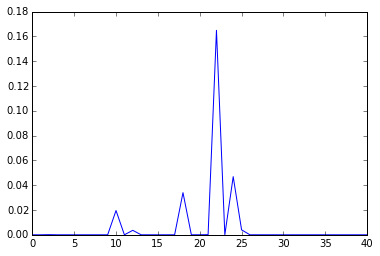

In [5]:
mag_err = np.ma.array(ccd.catalog.sources['psf_mag_err'])
mag_err.mask = ~np.isfinite(mag_err)
print 'rms', np.sqrt(np.ma.sum(mag_err**2)/len(mag_err))
print 'mean', np.ma.mean(mag_err)
print 'median', np.median(mag_err)
print 'stddev', np.std(mag_err)
ex = np.arange(0,len(mag_err))
ey = mag_err.filled(0)
plt.plot(ex,ey)

In [8]:
from scipy import spatial
KDTree = spatial.cKDTree
kdt = KDTree(objs)
d2, idx = kdt.query(zip(ccd.catalog.x,ccd.catalog.y))
print d2.shape
print idx.shape
print objs.shape
print objs[idx].shape

ccd.catalog.sources['refx'] = objs[idx][:,0]
ccd.catalog.sources['refy'] = objs[idx][:,1]
ccd.catalog.sources['d2'] = d2
ccd.catalog.sources['ref_amp'] = amplitudes[idx]
sources = ccd.catalog.sources
sources['mag_err'] = np.abs(sources['aper_mag']-sources['psf_mag'])

d2, idx = ccd.kd_tree.query(zip(ccd.catalog.x,ccd.catalog.y), 2)
sources['ndist'] = d2[:,1]
sources['idx'] = np.arange(0,len(sources),1)

(41,)
(41,)
(50, 2)
(41, 2)


In [9]:
print sources.colnames

['thresh', 'npix', 'tnpix', 'xmin', 'xmax', 'ymin', 'ymax', 'x', 'y', 'x2', 'y2', 'xy', 'a', 'b', 'theta', 'cxx', 'cyy', 'cxy', 'cflux', 'flux', 'cpeak', 'peak', 'xcpeak', 'ycpeak', 'xpeak', 'ypeak', 'flag', 'kron_radius', 'kron_flag', 'kron_flux', 'kron_flux_err', 'kron_eff_radius', 'half_flux_radius', 'xwin', 'ywin', 'kron_mag', 'kron_mag_err', 'aper_radius', 'aper_flux', 'aper_flux_err', 'aper_flag', 'aper_mag', 'aper_mag_err', 'src_idx', 'pipeline_flags', 'psf_flux', 'psf_flux_err', 'psf_mag', 'psf_mag_err', 'psf_x', 'psf_y', 'refx', 'refy', 'd2', 'ref_amp', 'mag_err', 'ndist', 'idx']


In [11]:
sources[sources['psf_mag_err']>.1]['idx','x','y','psf_mag_err',
                                   'mag_err','ndist','ref_amp','d2']

idx,x,y,psf_mag_err,mag_err,ndist,ref_amp,d2
int64,float64,float64,float64,float64,float64,float64,float64
22,266.277656279,171.99796924,0.164908093235,0.291616386982,12.6383807083,906.303144924,0.85023375763


Parameter('amplitude', value=646.24190818)
405.70134801


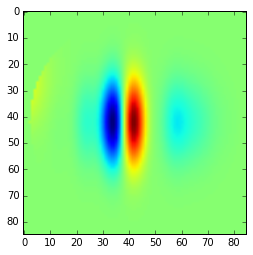

In [12]:
src_idx = 22
src_psf = astropyp.phot.psf.SinglePSF(ccd.psf._psf_array, 
            sources['peak'][src_idx], sources['x'][src_idx], sources['y'][src_idx])
flux, flux_err, residual, new_pos = src_psf.fit(data)
print src_psf.amplitude
print np.max(residual)
#print src_psf.fitter.fit_info
plt.imshow(residual)